# Extreme value analysis based on GTSM-ERA5 timeseries data

This notebook demonstrates the process of extreme value analysis for a specific station in the GTSM-ERA5 dataset, aiming to produce a more accurate estimate of the extreme return values than the return values data provided in the global dataset.  

The global dataset return values was created using a generic global approach using fixed thresholds (99th percentile) for the peak-over-threshold extreme value analysis. A more accurate analysis is possible by selecting appropriate thresholds based on the analysis of the timeseries at specific locations. This is demonstrated in this notebook with the help of the python library [pyextremes](https://georgebv.github.io/pyextremes/).

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import glob
from os import path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyextremes import EVA, get_extremes, plot_threshold_stability, plot_return_value_stability, plot_parameter_stability
from pyextremes.plotting import plot_extremes

In [ ]:
# paths to where to GTSM-ERA5 dataset is stored - outside of Deltares replace this with the paths to data downloaded from CDS!
filepath1 = r'p:\11210221-gtsm-reanalysis\GTSM-ERA5-E_dataset\waterlevel' #1950-1979, 2019-2024 data
filepath2 = r'p:\11210221-gtsm-reanalysis\GTSM-ERA5-E_dataset\waterlevel_1979_2018' #1979-2018 data

In [4]:
# locate files
filelist = glob.glob(path.join(filepath1,'reanalysis_waterlevel_hourly_*.nc')) + \
            glob.glob(path.join(filepath2,'reanalysis_waterlevel_hourly_*.nc'))
filelist.sort()

In [ ]:
# Sort list 
basenamelist = [path.basename(x) for x in filelist]
sort_ids = np.argsort(basenamelist)
filelist_sorted = [filelist[x] for x in sort_ids] 

In [ ]:
# Check number of files
len(filelist_sorted)

900

In [ ]:
# define locations of interest
locs = np.array([[16759, 103.286, 1.567],
[16758, 103.403, 1.421],
[39718, 103.433, 1.304],
[16757, 103.55, 1.333],
[38762, 103.931, 1.421],
[41778, 104.048, 1.392]]) # [index, lon, lat] # note: index is the positional index!

In [ ]:
# access the dataset    
ds = xr.open_mfdataset(filelist_sorted)
ds = ds.chunk(chunks={'time':'auto','stations':100})

In [10]:
# subset to locations of interest
ds_sel = ds.isel(stations=locs[:,0].astype(int),drop=True); ds.close()

In [ ]:
# load dataset selection into memory
ds_sel.load()

<xarray.Dataset> Size: 492kB
Dimensions:               (time: 8784, stations: 6)
Coordinates:
    station_x_coordinate  (stations) float64 48B 103.3 103.4 ... 103.9 104.0
    station_y_coordinate  (stations) float64 48B 1.567 1.421 ... 1.421 1.392
  * time                  (time) datetime64[ns] 70kB 2024-01-01 ... 2024-12-3...
  * stations              (stations) uint16 12B 16761 16760 ... 38806 42393
Data variables:
    waterlevel            (time, stations) float64 422kB -0.527 -0.524 ... 0.104
Attributes: (12/35)
    Conventions:                   CF-1.6
    featureType:                   timeSeries
    id:                            GTSMv3_totalwaterlevels
    naming_authority:              https://deltares.nl/en
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    title:                         Hourly timeseries of total water levels
    ...                            ...
    geospatial_vertical_max:       7.88
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  up
    time_coverage_start:           2024-01-01 00:00:00
    time_coverage_end:             2024-01-31 23:00:00
    experiment:                    reanalysis

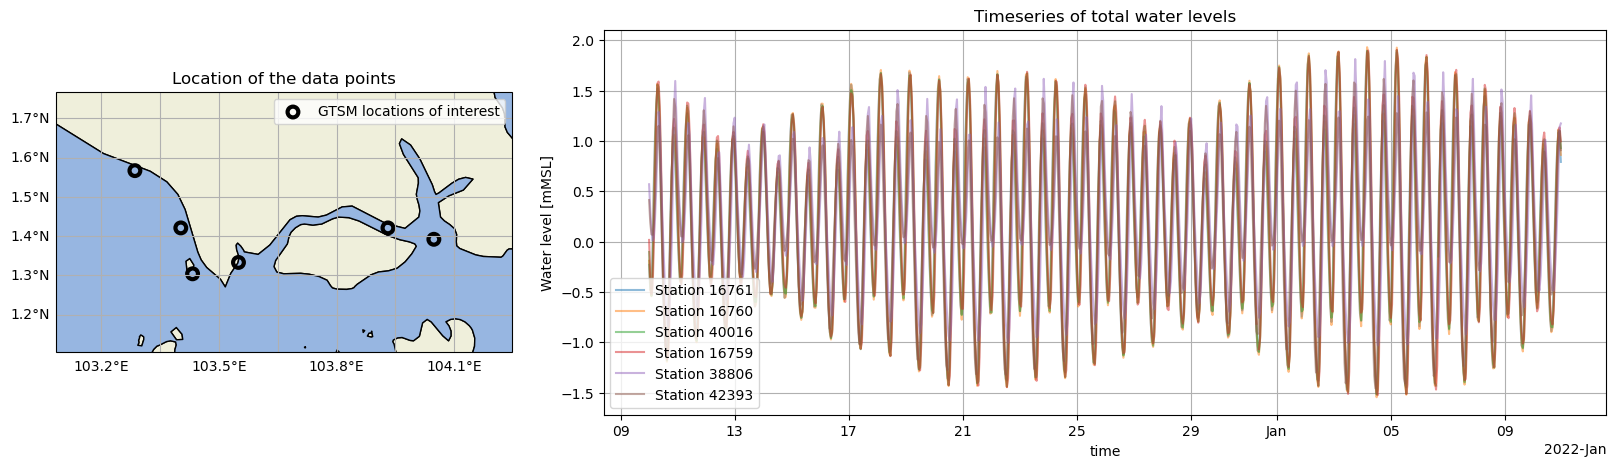

In [ ]:
# Plot locations on map and check timeseries for specific timeframe to understand the tidal range
fig = plt.figure(figsize=(20, 5))
ax0 = plt.subplot2grid((1, 3), (0, 0), projection=ccrs.PlateCarree())
ax1 = plt.subplot2grid((1, 3), (0, 1), colspan=2)

#    plot location on the map
ax0.set_ylim([np.min(locs[:, 2])-0.2, np.max(locs[:, 2])+0.2])
ax0.set_xlim([np.min(locs[:, 1])-0.2, np.max(locs[:, 1])+0.2])
ax0.add_feature(cfeature.LAND, edgecolor='black')
ax0.add_feature(cfeature.OCEAN, edgecolor='black')
gl = ax0.gridlines(draw_labels=True)
gl.top_labels = gl.right_labels = False
bs = ax0.scatter(x=locs[:, 1], y=locs[:, 2], s=60, transform=ccrs.PlateCarree(), facecolors='None',
                 edgecolors='black', linewidth=3, label='GTSM locations of interest')
ax0.title.set_text("Location of the data points")
ax0.legend()

# plot timeseries of water levels
ds_sel_dec21 = ds_sel.sel(time=slice('2021-12-10','2022-01-10'))
for ii,st in enumerate(ds_sel.stations.values):
    ds_sel_dec21['waterlevel'].sel(stations=st).plot(ax=ax1, alpha=0.5, label=f'Station {st}')
ax1.set_ylabel('Water level [mMSL]')
ax1.grid()
ax1.title.set_text('Timeseries of total water levels')
ax1.legend()
plt.savefig(path.join(r'p:\11210221-gtsm-reanalysis\GTSM-ERA5-E_dataset\ExtremeValueAnalysis',f'station_overview.png'))

In [ ]:
# Check SLR relative to 1986-2005 in 2024
ds_sel['waterlevel'].sel(time=slice('2024-01-01','2025-01-01')).mean()

<xarray.DataArray 'waterlevel' ()> Size: 8B
array(0.16913838)

In [11]:
# function for detrending timeseries of water levels (removing sea level rise component)
def detrend(ds: xr.DataArray, plot = False):
  ''' remove annual means and overall mean '''
  ds = ds.assign_coords(year=ds.time.dt.strftime("%Y"))
  ds = (ds.groupby("year") - ds.groupby("year").mean("time"))
  ds['wl_detrended'] = ds['waterlevel'] - ds['waterlevel'].mean()
  ds['wl_detrended'] = ds['wl_detrended'].chunk({"time": -1, "stations": "auto"})
  if plot == True:
      fig, axs = plt.subplots(nrows=2)
      ds.waterlevel.plot.line(x='time',ax=axs[0], add_legend=False)   
      ds.wl_detrended.plot.line(x='time',ax=axs[1],add_legend=False)  
  return ds

In [ ]:
# detrend timeseries
ds2 = detrend(ds_sel)
ds2 = ds2.drop_vars(['waterlevel'])

In [ ]:
# THRESHOLDS - NOTE: these are defined manually by checking the plots below. 
# To do this, please go station by station in the section below titled "Selecting thresholds for EVA" 
varth_all = [1.78, 1.81, 1.78, 1.76, 1.66, 1.51]

In [ ]:
# Compute all return periods
rps = [2, 5, 10, 25, 100]

def compute_eva_pyextremes(ds2,id,varth_all,rps,locs):
    varth = varth_all[id]
    var = ds2.wl_detrended.isel(stations=id)
    var = var.to_dataframe().loc[:, 'wl_detrended'].dropna()

    model = EVA(var)
    model.get_extremes("POT", threshold=varth, r="72h"); 
    model.fit_model(distribution='genpareto',model='MLE')

    summary = model.get_summary(return_period=rps,alpha=0.95)

    summary1 = summary.drop(columns=['lower ci','upper ci'])
    for i in range(0,len(rps)):
        summary1 = summary1.rename(index={summary1.index[i]:f'RP{rps[i]}'})    
    # summary2 = summary.drop(columns=['return value','upper ci']); summary2 = summary2.rename(columns={'lower ci':'return value'})
    # for i in range(0,len(rps)):
    #     summary2 = summary2.rename(index={summary2.index[i]:f'{rps[i]}_lower'}) 
    # summary3 = summary.drop(columns=['return value','lower ci']); summary3 = summary3.rename(columns={'upper ci':'return value'})
    # for i in range(0,len(rps)):
    #     summary3 = summary3.rename(index={summary3.index[i]:f'{rps[i]}_higher'}) 
    summary_all = pd.concat([summary1])#,summary2,summary3])

    tmp2 = pd.DataFrame([int(locs[id,0]),int(ds2.stations.values[id]),locs[id,1],locs[id,2]],index=['station_index','station_nr','lon','lat'],columns=summary_all.columns)
    potmodel = pd.concat([tmp2,summary_all])    
    potmodel = potmodel.transpose().set_index('station_index')

    potmodel.RP2 = potmodel.RP2.round(decimals=2)
    potmodel.RP5 = potmodel.RP5.round(decimals=2)
    potmodel.RP10 = potmodel.RP10.round(decimals=2)
    potmodel.RP25 = potmodel.RP25.round(decimals=2)
    potmodel.RP100 = potmodel.RP100.round(decimals=2)
    return potmodel

In [ ]:
# loop over locations and compute return periods using the thresholds defined in the 'varth_all' variable
ds_gtsm_eva = compute_eva_pyextremes(ds2,0,varth_all,rps,locs)
for id in range(len(locs)):    
    ds_gtsm_eva = pd.concat([ds_gtsm_eva,compute_eva_pyextremes(ds2,id,varth_all,rps,locs)]) 
print(ds_gtsm_eva)

               station_nr      lon    lat   RP2   RP5  RP10  RP25  RP100
station_index                                                           
16759.0           16761.0  103.286  1.567  1.81  1.83  1.86  1.89   1.94
16759.0           16761.0  103.286  1.567  1.81  1.83  1.86  1.89   1.94
16758.0           16760.0  103.403  1.421  1.85  1.88  1.91  1.94   1.98
39718.0           40016.0  103.433  1.304  1.84  1.87  1.90  1.94   1.99
16757.0           16759.0  103.550  1.333  1.85  1.89  1.91  1.95   2.00
38762.0           38806.0  103.931  1.421  1.72  1.76  1.79  1.82   1.87
41778.0           42393.0  104.048  1.392  1.57  1.60  1.63  1.66   1.71


In [ ]:
# Save results to a csv file
ds_gtsm_eva.to_csv(path.join(r'p:\11210221-gtsm-reanalysis\GTSM-ERA5-E_dataset\ExtremeValueAnalysis',f'EVA_summary_20250216.csv'))

## Selecting thresholds for EVA

The code below is used to find thresholds - requires looking at plots and choosing a value to put in the varth_all variable. For some explanations on how this is done please check the [pyextremes manual](https://georgebv.github.io/pyextremes/user-guide/5-threshold-selection/).

In [ ]:
# Select station from the list defined above in variable 'locs'
id = 2
st = ds2.stations.values[id]

In [ ]:
# select data
var = ds2.wl_detrended.sel(stations=st)
var = var.to_dataframe().loc[:, 'wl_detrended'].dropna()

var_max = np.floor(np.nanmax(var)*10)/10

In [152]:
#plot_mean_residual_life(var)

<Axes: xlabel='Threshold', ylabel='Return value'>

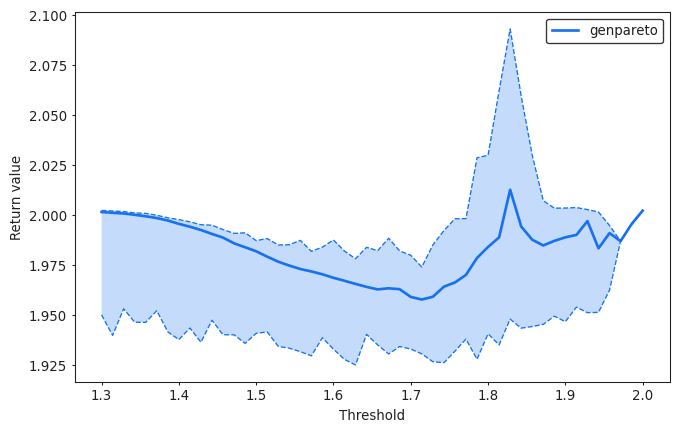

In [181]:
plot_return_value_stability(
    var,
    return_period=100,
    thresholds=np.linspace(1.3, var_max, 50),
    distributions=['genpareto'],
    alpha=0.95,
)

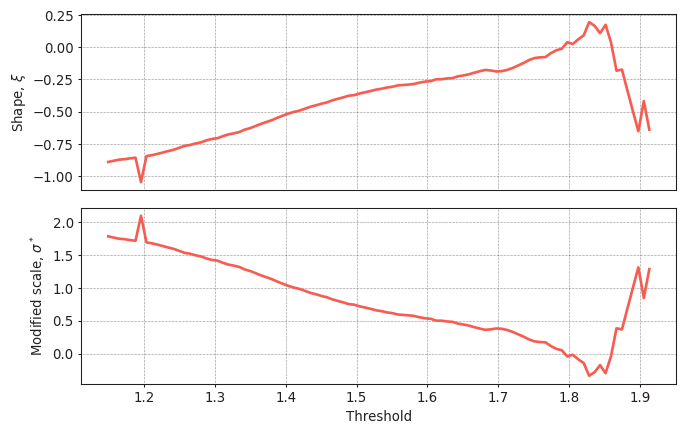

In [ ]:
plot_parameter_stability(var)
plt.savefig(path.join(r'p:\11210221-gtsm-reanalysis\GTSM-ERA5-E_dataset\ExtremeValueAnalysis\figures',f'station_{st}_parameter_stability.png'))

In [ ]:
var_max

ZeroDivisionError: division by zero

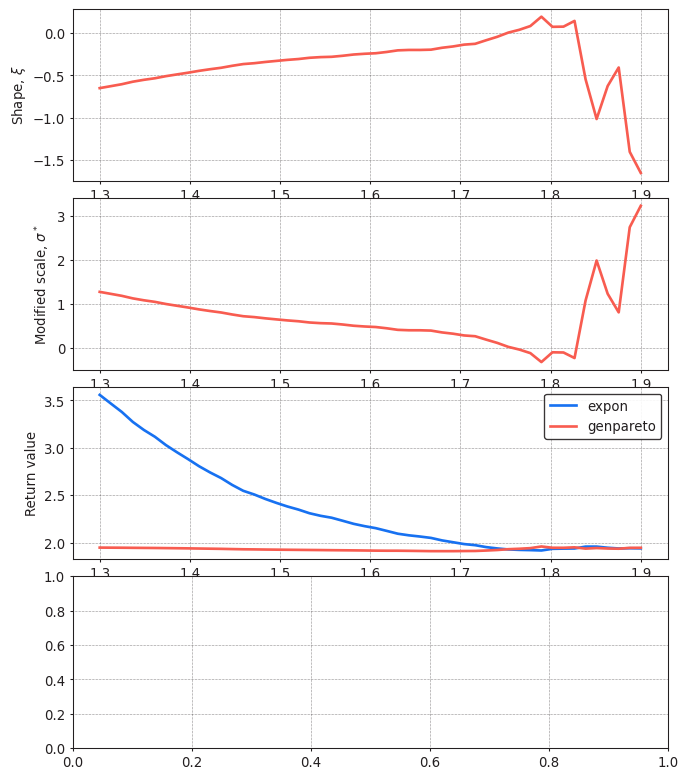

In [155]:
plot_threshold_stability(
    var,
    return_period=100,
    thresholds=np.linspace(1.3, var_max, 50),
)

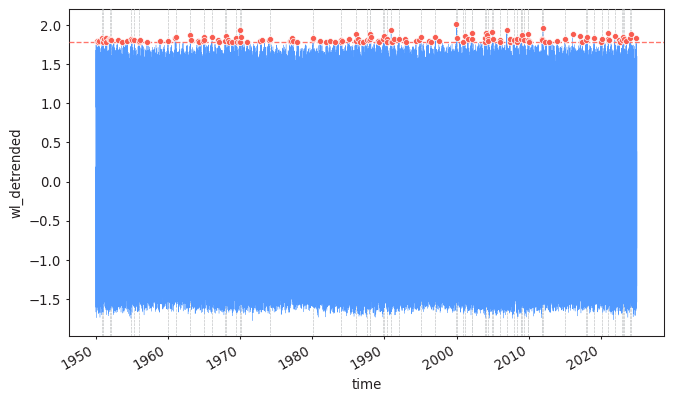

In [ ]:
extremes = get_extremes(var, "POT", threshold=varth_all[id], r="72h")
plot_extremes(
    ts=var,
    extremes=extremes,
    extremes_method="POT",
    extremes_type="high",
    threshold=varth_all[id],
    r="72h",
)
plt.savefig(path.join(r'p:\11210221-gtsm-reanalysis\GTSM-ERA5-E_dataset\ExtremeValueAnalysis\figures',f'station_{st}_POT_extremes_thresh_{varth_all[id]:.2f}.png'))

In [ ]:
# Perform EVA
varth = varth_all[id]
model = EVA(var)
model.get_extremes("POT", threshold=varth, r="72h"); 
model.fit_model(distribution='genpareto',model='MLE')

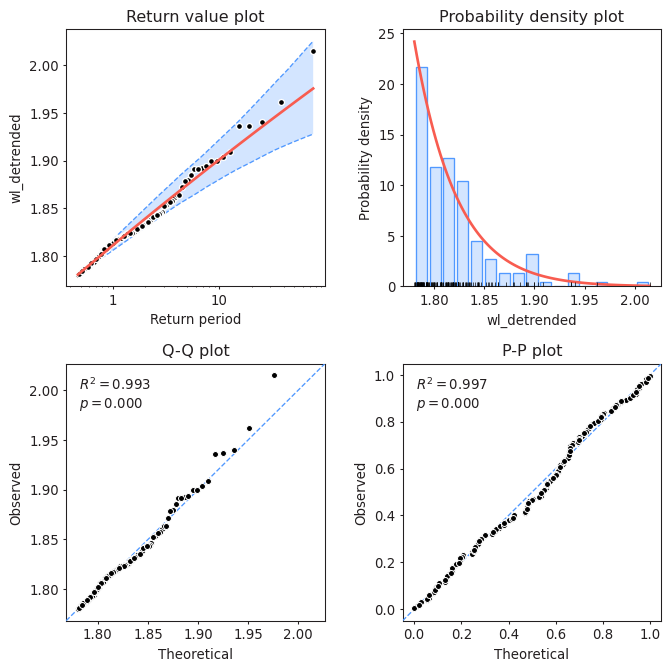

In [ ]:
# Plot diagnostic of the EVA to check the fit
model.plot_diagnostic(alpha=0.95);
plt.savefig(path.join(r'p:\11210221-gtsm-reanalysis\GTSM-ERA5-E_dataset\ExtremeValueAnalysis\figures',f'station_{st}_EVA_diagnostic.png'))